![](https://www.paho.org/sites/default/files/styles/top_hero/public/2022-07/coronavirus-ilustracion.jpg?h=4aea44c5&itok=HX70CyU6)

[![](https://img.shields.io/badge/acceso%20al%20notebook-COVID__19__Italia.ipynb-sucess?style=for-the-badge&logo=google-colab&color=ff8000)](https://colab.research.google.com/drive/1qB19OTY4_ibC-7eW9a_F7tlQ3k8p_vO9?usp=sharing)

# **PROBLEMA DE NEGOCIO**


---

Una entidad gubernamental responsable de la gestión de la salud de **Italia** (pais seleccionado) enfrenta el desafío de comprender y analizar la propagación del COVID-19 para tomar decisiones informadas y eficaces en la gestión de la pandemia.

## **Configuración del Ambiente**

In [1]:
''' Descomentar este para instalar todo
%%bash
pip install --upgrade pip
pip install -r requirements.txt
'''
!python -V

Python 3.11.7


In [2]:
"""
    Con esta versión en Python 3.11.7 
    me salía RuntimeWarning y DataFrameGroupBy
    y no podía corregirlo para que quede estético
    en deepnote usa 3.11.4 y en google-colab la 3.10.12 
    no muestra el error
"""


import warnings


warnings.filterwarnings(
    "ignore",
    message="DataFrameGroupBy.apply operated on the grouping columns"
)

warnings.filterwarnings(
    "ignore", category=RuntimeWarning
)

## **Obtención, Tratamiento y Análisis Exploratorio (EDA)**

In [3]:
# Cargando las bases de datos
import pandas as pd
from io import StringIO
import requests as req


df_covid = pd.read_csv(
    StringIO(
        req.get(
            "https://covid19.who.int/WHO-COVID-19-global-data.csv"
        ).text
    )
)


df_population = pd.read_excel(
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx',
    sheet_name=0, skiprows=16
)
df_population = df_population[df_population['Year'] == 2019]

In [4]:
#df_population

In [5]:
#df_covid

In [6]:
'''
    Transformar datos de df_covid
'''

covid_transform = df_covid.copy()

covid_transform = covid_transform.dropna(subset=['Country_code'])


covid_transform = covid_transform[
    [
        'Date_reported','Country_code','Country',
        'New_cases','Cumulative_cases','New_deaths',
        'Cumulative_deaths'
    ]
]


covid_transform = covid_transform.fillna(0)

covid_transform['Date_reported'] = pd.to_datetime(
    covid_transform['Date_reported']
)
covid_transform['New_cases'] = covid_transform['New_cases'].astype('int64')
covid_transform['New_deaths'] = covid_transform['New_deaths'].astype('int64')

covid_cleaned = covid_transform.copy()

covid_cleaned['lethality_rate'] = (
    covid_cleaned['Cumulative_deaths'] / covid_cleaned['Cumulative_cases']
) * 100

covid_cleaned = covid_cleaned.reset_index(drop=True)

In [7]:
covid_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49396 entries, 0 to 49395
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date_reported      49396 non-null  datetime64[ns]
 1   Country_code       49396 non-null  object        
 2   Country            49396 non-null  object        
 3   New_cases          49396 non-null  int64         
 4   Cumulative_cases   49396 non-null  int64         
 5   New_deaths         49396 non-null  int64         
 6   Cumulative_deaths  49396 non-null  int64         
 7   lethality_rate     45307 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


In [8]:
covid_cleaned.describe()

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
count,49396,4.939600e+04,4.939600e+04,49396.000000,4.939600e+04,4.530700e+04
mean,2022-01-12 12:00:00.000000256,1.567324e+04,1.643477e+06,142.040530,1.928293e+04,inf
min,2020-01-05 00:00:00,-6.507900e+04,0.000000e+00,-3432.000000,0.000000e+00,0.000000e+00
25%,2021-01-08 06:00:00,0.000000e+00,3.846750e+03,0.000000,2.900000e+01,5.128205e-01
50%,2022-01-12 12:00:00,1.020000e+02,4.283250e+04,0.000000,4.980000e+02,1.181060e+00
75%,2023-01-16 18:00:00,1.999250e+03,4.998840e+05,20.000000,6.630250e+03,2.160936e+00
max,2024-01-21 00:00:00,4.047548e+07,1.034368e+08,47687.000000,1.165780e+06,inf
std,NaN,2.408294e+05,7.274286e+06,875.025827,7.909933e+04,NaN


In [9]:
#covid_cleaned

In [10]:
"""
    Transformar datos de df_population
"""

population_transform = df_population.copy()

population_transform = population_transform[
    [
        'ISO2 Alpha-code',
        'Total Population, as of 1 July (thousands)',
        'Male Population, as of 1 July (thousands)',
        'Female Population, as of 1 July (thousands)',
        'Population Density, as of 1 July (persons per square km)',
        'Life Expectancy at Birth, both sexes (years)'
    ]
]

population_transform = population_transform.rename(
    columns={
        'ISO2 Alpha-code': 'Country_code',
        'Total Population, as of 1 July (thousands)': 'Total_Population',
        'Male Population, as of 1 July (thousands)': 'Male_Population',
        'Female Population, as of 1 July (thousands)': 'Female_Population',
        'Population Density, as of 1 July (persons per square km)': 'Population_Density',
        'Life Expectancy at Birth, both sexes (years)': 'Life_Expectancy'
    }
)

population_cleaned = population_transform.dropna().copy()

population_cleaned['Life_Expectancy'] = pd.to_numeric(
    population_cleaned['Life_Expectancy'], errors='coerce'
).fillna(0).astype('float64')

columns_to_convert = [
    'Total_Population', 'Male_Population',
    'Female_Population', 'Population_Density'
]

for column in columns_to_convert:
    population_cleaned[column] = pd.to_numeric(
        population_cleaned[column], errors='coerce'
    ).fillna(0).astype('int64')

population_cleaned[
    ['Total_Population', 'Male_Population', 'Female_Population']
] *= 1000

population_cleaned = population_cleaned.dropna()

population_cleaned = population_cleaned.reset_index(drop=True)

In [11]:
#population_cleaned

In [12]:
population_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country_code        236 non-null    object 
 1   Total_Population    236 non-null    int64  
 2   Male_Population     236 non-null    int64  
 3   Female_Population   236 non-null    int64  
 4   Population_Density  236 non-null    int64  
 5   Life_Expectancy     236 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.2+ KB


In [13]:
population_cleaned.describe()

,Total_Population,Male_Population,Female_Population,Population_Density,Life_Expectancy
count,2.360000e+02,2.360000e+02,2.360000e+02,236.000000,236.000000
mean,3.289144e+07,1.654706e+07,1.634390e+07,461.677966,73.178106
std,1.342185e+08,6.875309e+07,6.547831e+07,2217.981940,8.765629
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.935000e+05,1.907500e+05,2.075000e+05,38.000000,68.459250
50%,5.400500e+06,2.731500e+06,2.709500e+06,95.000000,74.960000
75%,2.066300e+07,1.039800e+07,1.026425e+07,240.500000,79.081750
max,1.421864e+09,7.267810e+08,6.950820e+08,24855.000000,86.542000


In [14]:
import squarify
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Como científico de datos, tu tarea es analizar los datos relacionados con el COVID-19 y presentar insights a través de visualizaciones que respondan a las siguientes preguntas clave:

## 1. ¿Cómo ha evolucionado el Covid-19 en el país en comparación con el impacto observado a nivel global?



In [15]:
# Worldwide Distribution

replacement = {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK'
}

covid_cleaned.replace(replacement, inplace=True)

total_por_pais = (
    covid_cleaned.groupby('Country')['Cumulative_cases']
    .max()
    .sort_values(ascending=False)
)

top_10_paises = total_por_pais.nlargest(10)
otros = total_por_pais.drop(top_10_paises.index).sum()
top_10_paises['Otros'] = otros
top_10_paises

Country
USA                  103436829
China                 99326423
India                 45023751
France                38997490
Germany               38437756
Brazil                37519960
Republic of Korea     34571873
Japan                 33803572
Italy                 26693706
UK                    24885790
Otros                291531799
Name: Cumulative_cases, dtype: int64

In [16]:
total_por_pais = (
    covid_cleaned
    .groupby('Country')['Cumulative_cases']
    .max()
    .sort_values(ascending=False)
)

top_5_paises = total_por_pais.nlargest(5)

top_5_paises.loc['Italy'] = total_por_pais.loc['Italy']

df_covid_limpio_reset = covid_cleaned.reset_index()

df_top_5 = df_covid_limpio_reset[
    df_covid_limpio_reset['Country'].isin(top_5_paises.index)
    ]

total_acumulado_top_5 = df_top_5.pivot(
    index='Country',
    columns='Date_reported',
    values='Cumulative_cases'
).fillna(0)

total_acumulado_top_5

Date_reported,2020-01-05,2020-01-12,2020-01-19,2020-01-26,2020-02-02,2020-02-09,2020-02-16,2020-02-23,2020-03-01,2020-03-08,...,2023-11-19,2023-11-26,2023-12-03,2023-12-10,2023-12-17,2023-12-24,2023-12-31,2024-01-07,2024-01-14,2024-01-21
Country,,,,,,,,,,,,,,,,,,,,,
China,1,45,125,1985,14411,37251,68584,77042,79968,80859,...,99320035,99320425,99320845,99321242,99321637,99322142,99322727,99323756,99325108,99326423
France,0,0,0,3,6,12,12,16,16,16,...,38997490,38997490,38997490,38997490,38997490,38997490,38997490,38997490,38997490,38997490
Germany,1,1,1,2,11,20,25,31,170,1075,...,38437756,38437756,38437756,38437756,38437756,38437756,38437756,38437756,38437756,38437756
India,0,0,0,0,2,7,7,7,7,39,...,45001575,45001764,45002179,45003055,45004816,45008620,45013172,45018134,45021758,45023751
Italy,0,0,0,0,3,3,3,79,1128,5883,...,26340704,26390074,26446300,26499900,26565654,26623153,26658028,26679299,26691441,26693706
USA,0,0,0,7,9,20,24,40,73,464,...,103436829,103436829,103436829,103436829,103436829,103436829,103436829,103436829,103436829,103436829


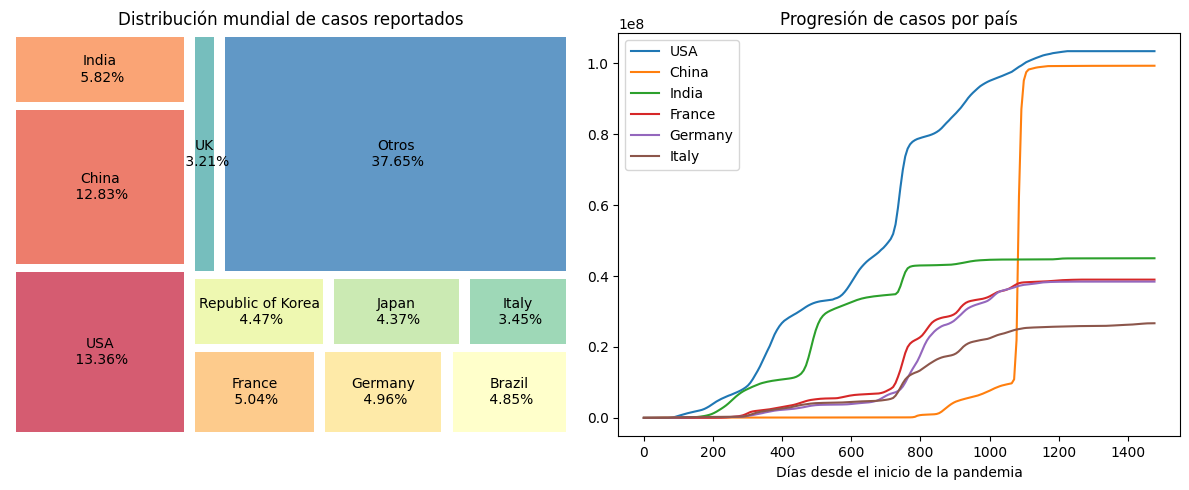

In [17]:
"""
    Gráficos de Treemap con Líneas
"""

percentages = [(value / total_por_pais.sum()) * 100 for value in top_10_paises.to_list()]

# Crea las etiquetas con los porcentajes
labels = [f'{country}\n {value:.2f}%' for country, value in zip(top_10_paises.index.to_list(), percentages)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Treemap con Squarify en axs[0]
squarify.plot(
    sizes=top_10_paises.to_list(),
    ax=axs[0], pad=2,
    label=labels, alpha=.8,
    color=sns.color_palette("Spectral", len(top_10_paises))
)
axs[0].set_title('Distribución mundial de casos reportados')
axs[0].axis('off')

# Gráfico de Líneas en axs[1]
for pais in top_5_paises.index:
    days_since_start = (
        total_acumulado_top_5.columns - total_acumulado_top_5.columns[0]
        ).days
    axs[1].plot(days_since_start, total_acumulado_top_5.loc[pais], label=pais)

axs[1].set_title('Progresión de casos por país')
axs[1].set_xlabel('Días desde el inicio de la pandemia')
axs[1].legend()

plt.savefig('evolucion_italia_vs_mundo.png')
plt.tight_layout()
plt.show()


Italia se encuentra en la posición 9 de los países con mayores casos de COVID acumulados hasta la fecha, ha experimentado un crecimiento moderado pero constante de los casos de COVID-19 en comparación con otros países. Si bien en el año 2022 hubo un aumento considerable de casos diarios, fue menor que en lo observado en los otros países del top 5.

## 2.¿Cuál ha sido la evolución de los nuevos casos diarios reportados de Covid-19 en el país a lo largo del tiempo?

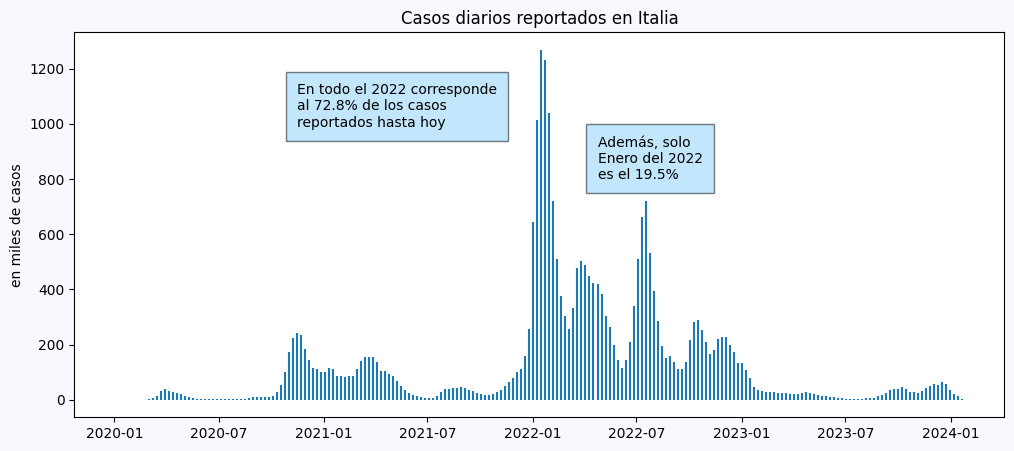

In [18]:
#Daily New Cases
grouped_df = (
    covid_cleaned
    .groupby(['Country', 'Date_reported'])['Cumulative_cases']
    .sum()
    .unstack()
)

grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.set_index('Country')
grouped_df = grouped_df.loc[['Italy']]
fechas = grouped_df.columns

new_cases = (
    grouped_df[fechas]
    .diff(axis=1)
    .fillna(grouped_df[fechas])
    .sum(axis=0)
)


calplot_new_cases = new_cases.copy()
calplot_new_cases.index = pd.to_datetime(calplot_new_cases.index)
calplot_2022 = calplot_new_cases.loc['2022']


fig, ax = plt.subplots(figsize=(12, 5),facecolor='#F8F8FF')

ax.stem(
    new_cases.index, new_cases.values/1e3, basefmt='None', markerfmt= ''
    )


plt.text(
    new_cases.index[120], 800,
    f'Además, solo\nEnero del 2022\nes el {round((calplot_2022[calplot_2022.index.month == 1].sum() * 100 / top_10_paises["Italy"]), 1)}%',
    bbox = {'facecolor': '#87CEFA', 'alpha': 0.5, 'pad': 8}
    )

plt.text(
    new_cases.index[45], 990,
    f'En todo el 2022 corresponde\nal {round((calplot_2022.sum() * 100 / top_10_paises["Italy"]), 1)}% de los casos\nreportados hasta hoy',
    bbox = {'facecolor': '#87CEFA', 'alpha': 0.5, 'pad': 8}
    )

plt.ylabel('en miles de casos')
plt.title('Casos diarios reportados en Italia')
plt.savefig('italia_casos_diarios.png')

plt.show()

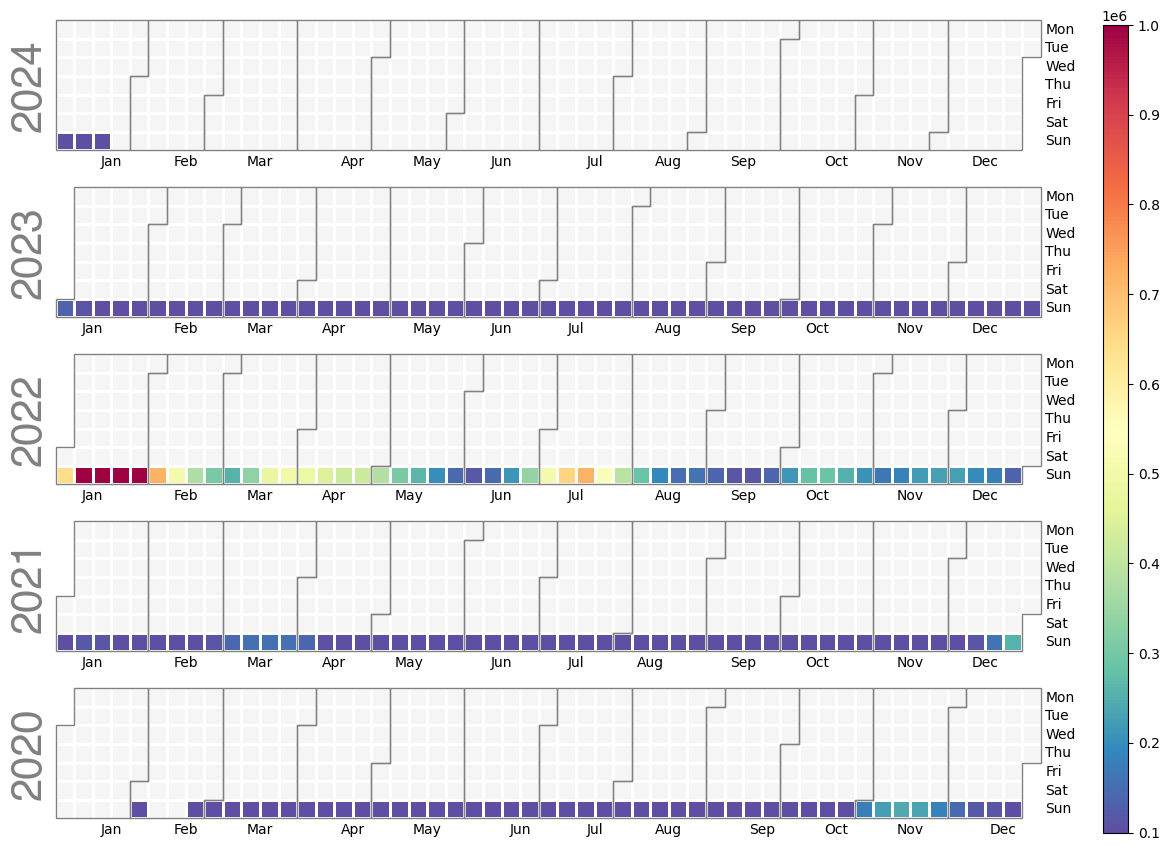

In [19]:
"""
    Este fue que me dejó ver que se borraron reportes por limpiar datos outsiders
    en la variable de letalidad
    
    Para usar la librería calplot se debe descargar
    la fuente Helvetica y cargar a matplotlib
"""

import os
import calplot
from matplotlib.font_manager import fontManager,FontProperties


fontManager.addfont(f'{os.getcwd()}/Helvetica.ttf')

calplot.calplot(
    calplot_new_cases, cmap = 'Spectral_r',
    vmin=1e5, vmax=1e6, yearascending = False
    )

plt.show()

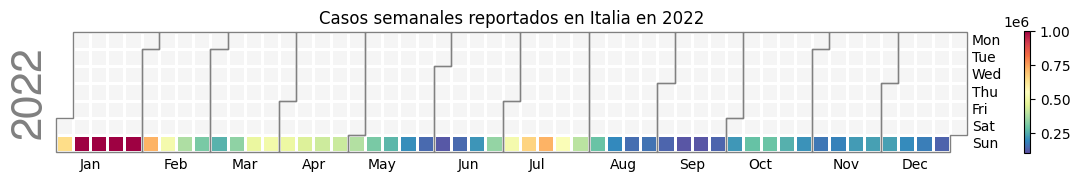

In [20]:
calplot.calplot(
    calplot_2022,
    cmap = 'Spectral_r',
    vmin=1e5, vmax=1e6
    )


plt.title('Casos semanales reportados en Italia en 2022')
plt.savefig('calplot_italia_2022.png')

plt.show()

Los datos indican que en el año 2022 es donde se reportan una mayor cantidad de casos. Observándose varios picos principalmente en Enero que éste duró hasta fines de Febrero, luego gradualmente picos menores en las quinceras de Julio y Octubre.

## 3. ¿Cuál es la evolución del índice de letalidad del Covid-19 en el país, comparado con los países con los índices históricos más elevados?

In [21]:
#Lethality Rate by Country - Limpieza de Datos

quantile_0 = covid_cleaned['lethality_rate'].quantile(0)
quantile_99 = covid_cleaned['lethality_rate'].quantile(0.99)

covid_lethality = covid_cleaned[
    (
        covid_cleaned['lethality_rate'] >= quantile_0
    ) & (
        covid_cleaned['lethality_rate'] <= quantile_99
    )
]

covid_lethality = covid_lethality.reset_index(drop=True)


covid_lethality.describe()

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,lethality_rate
count,44853,4.485300e+04,4.485300e+04,44853.000000,4.485300e+04,44853.000000
mean,2022-03-01 15:40:15.330078464,1.722128e+04,1.809406e+06,151.147125,2.114609e+04,1.595293
min,2020-01-05 00:00:00,-6.507900e+04,1.000000e+00,-3432.000000,0.000000e+00,0.000000
25%,2021-03-14 00:00:00,5.000000e+00,8.173000e+03,0.000000,7.300000e+01,0.504360
50%,2022-03-13 00:00:00,1.720000e+02,6.399300e+04,1.000000,8.030000e+02,1.164988
75%,2023-02-19 00:00:00,2.624000e+03,6.263340e+05,26.000000,7.975000e+03,2.126546
max,2024-01-21 00:00:00,4.047548e+07,1.034368e+08,47687.000000,1.165780e+06,12.776413
std,NaN,2.526782e+05,7.614161e+06,905.888414,8.276044e+04,1.666892


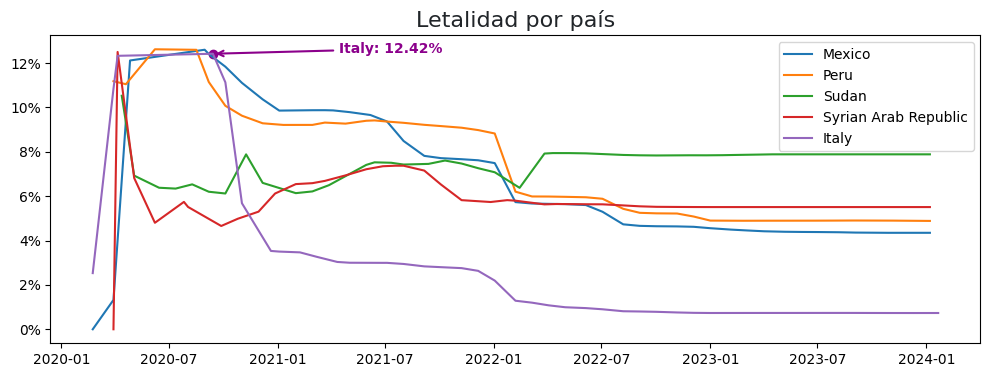

In [22]:
def get_max_row(group, column):
    return group.loc[group[column].idxmax()]

result = covid_lethality.groupby(
    ['Country', covid_lethality['Date_reported'].dt.to_period("M")]
    ).apply(lambda group: get_max_row(group, 'lethality_rate')
)

result.reset_index(drop=True, inplace=True)
top_4_paises = (
    result.groupby('Country')['lethality_rate']
    .mean()
    .nlargest(4)
    .index
)

result = result[result['Country'].isin(top_4_paises)]

result_pais = (
    covid_lethality[covid_lethality['Country'] == 'Italy']
    .groupby(
        covid_lethality['Date_reported'].dt.to_period("M"))
    .apply(lambda group: get_max_row(group, 'lethality_rate'))
)

result_pais.reset_index(drop=True, inplace=True)
result_final = pd.concat([result, result_pais])

fig, ax = plt.subplots(figsize=(12, 4))
for pais in result_final['Country'].unique():
    country_data = result_final[result_final['Country'] == pais]
    ax.plot(
        country_data['Date_reported'],
        country_data['lethality_rate'],
        label=pais
        )


# Agrega un punto en el máximo pico de letalidad para Italia

max_lethality_index = result_pais['lethality_rate'].idxmax()
max_lethality_date = result_pais.loc[max_lethality_index, 'Date_reported']
max_lethality_value = result_pais.loc[max_lethality_index, 'lethality_rate']


ax.scatter(
    max_lethality_date,
    max_lethality_value,
    color='#8b008b', marker='o'
    )

ax.annotate(
    f'Italy: {max_lethality_value:.2f}%',
    xy=(max_lethality_date, max_lethality_value),
    xytext=(
        max_lethality_date + pd.DateOffset(days=300),
        max_lethality_value - 0.1
    ),  # Ajusta la posición del texto
    arrowprops=dict(
        color='#8b008b', arrowstyle='->', lw=1.5
        ),  # Estilo de la flecha
    fontsize=10, color='#8b008b',
    ha='center', va='bottom', weight='bold'
)


# Agregando porcentaje en el eje Y

def porcent_formatter(y, pos):
    return f'{y*1:.0f}%'

formatter = FuncFormatter(porcent_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

ax.legend()

ax.set_title(
    'Letalidad por país', fontsize=16,
    color='#212529', loc='center'
    )

plt.savefig('letalidad_por_pais.png')


plt.show()

Italia llega a tener su pico de letalidad fue de 12.47%, para septiembre del 2020. Disminuyendo en diciembre del mismo año a un 3.5% llegando a valores de menos de 1,5% a partir de febrero del 2022.

## 4. Desde una perspectiva demográfica, ¿cuáles son las características que tienen un mayor impacto en el índice de letalidad de un país?

In [23]:
#Características demográficas más relevantes
df_filtrado = covid_lethality[
    covid_lethality['Date_reported'] <= '2020-12-31'
    ]

df_agrupado = df_filtrado.groupby(
    ['Country_code', 'Country'], as_index=False
)['lethality_rate'].mean()

df_final = pd.merge(
    df_agrupado, population_cleaned, on='Country_code', how='inner'
    )

columnas_seleccionadas = [
    'lethality_rate', 'Total_Population', 'Male_Population',
    'Female_Population', 'Population_Density', 'Life_Expectancy',
    ]

df_final = df_final[columnas_seleccionadas]


# Para hacer Regresión con Bosques Aleatorios

X = df_final.drop(['lethality_rate'], axis=1)
y = df_final['lethality_rate']
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = pd.Series(
    model.feature_importances_, index=X.columns
).sort_values(ascending=False)


# Para Matriz de Correlación
(
    df_final
    .corr()[['lethality_rate']]
    .sort_values(by='lethality_rate', ascending = False)
)

,lethality_rate
lethality_rate,1.000000
Life_Expectancy,0.110051
Female_Population,0.095142
Total_Population,0.093038
Male_Population,0.091018
Population_Density,-0.089846


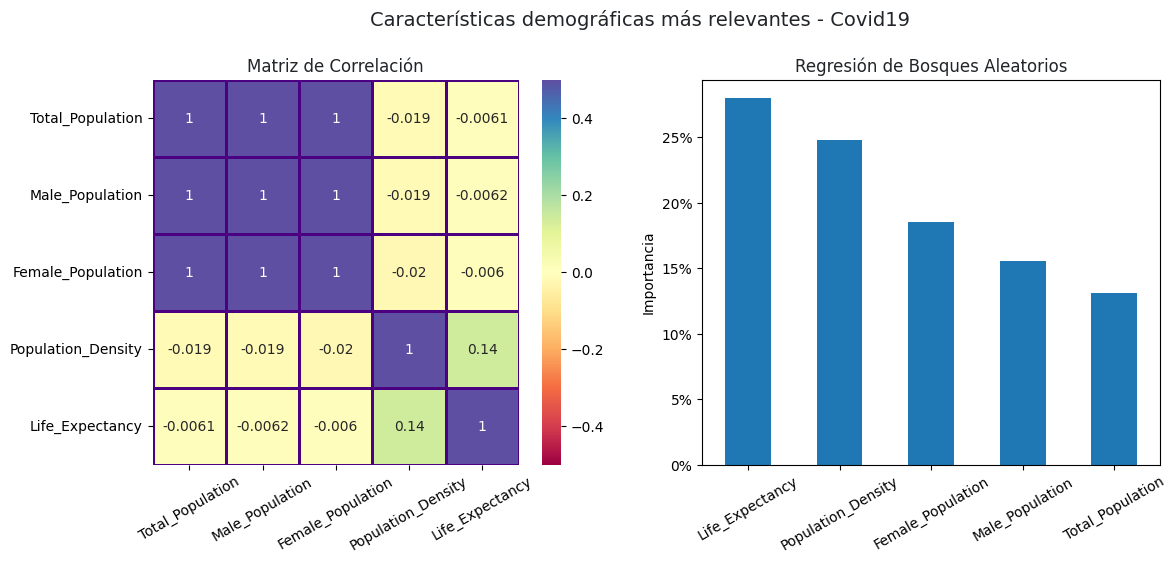

In [24]:
# Para graficar Matriz de Correlación y el de Árbol de Decisiones

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

fig.suptitle(
    'Características demográficas más relevantes - Covid19',
    fontsize=14, color='#212529', y=1.02
)

# Matriz de Correlación

axs[0].set_title(
    'Matriz de Correlación',
    fontsize=12, color='#212529', loc='center'
)

covid_corr = df_final.drop(['lethality_rate'], axis=1)

sns.heatmap(
    covid_corr.corr(), annot=True, cmap='Spectral', ax=axs[0],
    linewidths=2, linecolor='indigo', vmin=-0.5, vmax=0.5
)

axs[0].tick_params(axis='x', rotation=30)

# Random Forest Regressor

feature_importances.plot(kind='bar', ax=axs[1])

# Para el eje Y poner porcentaje

def porcentaje_formatter(y, pos):
    return f'{y*100:.0f}%'

formatter = FuncFormatter(porcentaje_formatter)

axs[1].yaxis.set_major_formatter(formatter)
axs[1].tick_params(axis='x', rotation=30)
axs[1].set_ylabel('Importancia')

axs[1].set_title(
    'Regresión de Bosques Aleatorios',
    fontsize=12, color='#212529', loc='center'
)

plt.savefig('demografia_relevante.png')

plt.show()

Aunque en primera instancia estudiando la regresión del Random Forest muestra que la población es una característica de alto impacto la verdad con la matriz de correlación concluye que más sería la densidad poblacional una característica importante descartando la cantidad de población del país con sus respectivas cifras entre sexos.

Podemos decir que la esperanza de vida __`Life_Expectancy`__ y la densidad poblacional __`Population_density`__ son las características que tienen un mayor impacto en el índice de letalidad.

# Conclusiones

Cabe destacar que durante el 2020 registrando 10000 casos semanales de promedio tuvo una alta letalidad llegando al 12% lo cual es muy peligroso para cualquier sistema de salud que puede colapsar repentinamente, sin embargo llegando al 2022 alcanzando el pico de casos reportados e incluso representando la mayor cantidad de casos acumulados hasta la fecha, tiene una letalidad menor al 2% destacando a pesar del brote masivo de ese año no era muy mortal para la gente.

> Se recomenda estudiar esta relación del año 2022 con la vacunación que relaciones tienen las personas que no se aplicaron las vacunas con las nuevas muertes registradas.

## Información de sesión
---

In [25]:
import session_info

session_info.show()